# Simple harmonic oscillator physics-informed neural network (PINN)

Code for simple harmonic oscillator based on Ben Mosely's implementation, Github link below: \\

* https://github.com/benmoseley/harmonic-oscillator-pinn

### Imports

---

In [44]:
from PIL import Image
from scipy.integrate import solve_ivp
from __future__ import division, print_function

import time
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

### Oscillator Definition

---

In [45]:
# Helper function for saving GIFs
def save_gif_PIL(outfile, files, fps=5, loop=0):
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

# 1D Underdamped Harmonic Oscillator
def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem.
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

### Neural Network Definition

---

In [28]:
# Fully connected neural network
class FCN(nn.Module):

    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

d, w0 = 2, 20

### Analytical Solution

---

torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([10, 1]) torch.Size([10, 1])


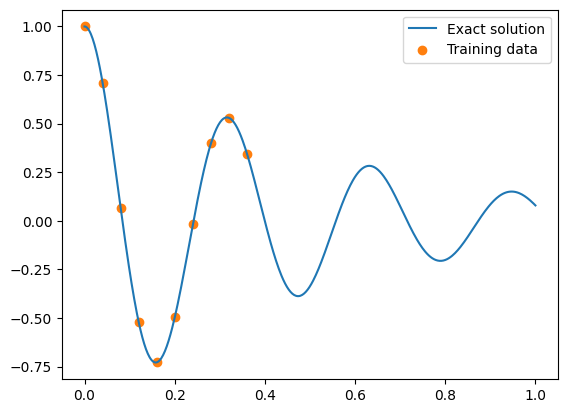

In [46]:
# get the analytical solution over the full domain
x = torch.linspace(0,1,500).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)
print(x.shape, y.shape)

# slice out a small number of points from the LHS of the domain
x_data = x[0:200:20]
y_data = y[0:200:20]
print(x_data.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

### Plotting

---

In [30]:
def plot_result(x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))

    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")

    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")

    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')

    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4,
                    label='Physics loss training locations')
    plt.legend(loc='upper right')
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.xlabel('t')
    plt.ylabel('y(t)')
    plt.title('Solution of the Underdamped Harmonic Oscillator')
    plt.grid(True)

### Training

---

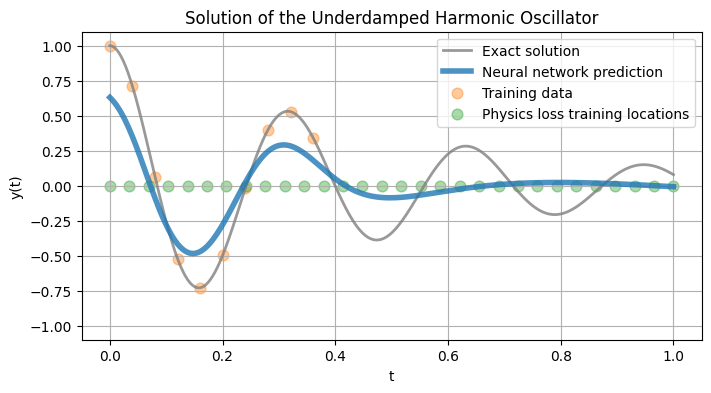

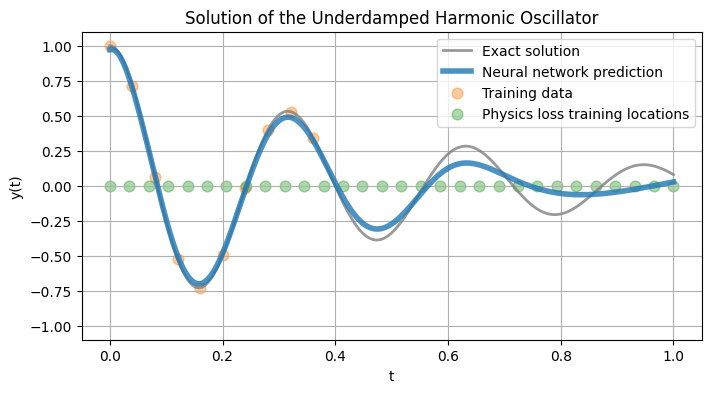

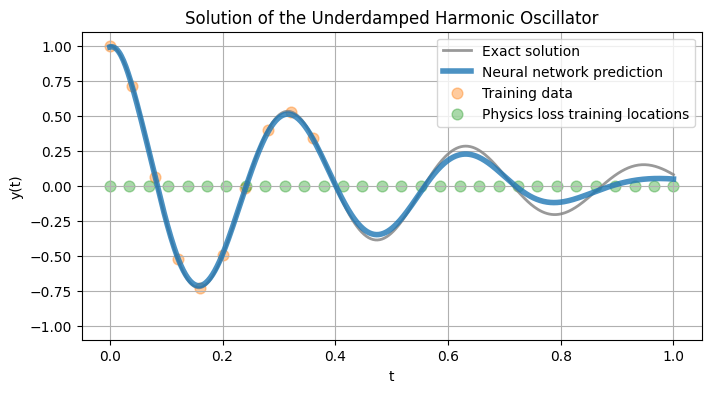

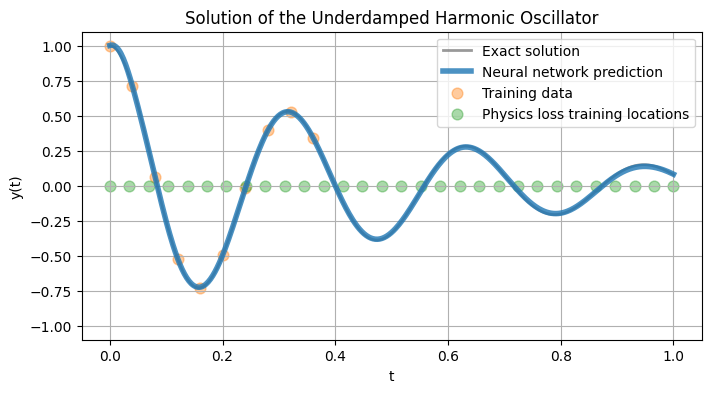

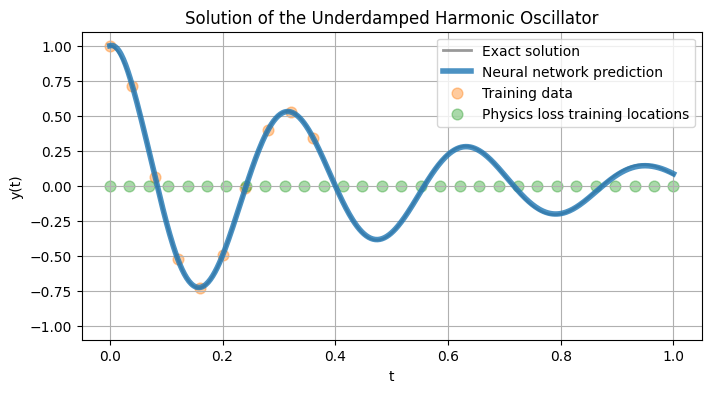

In [39]:
# train standard neural network to fit training data
torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
files = []

for i in range(1000):
    optimizer.zero_grad()
    yh = model(x_data)
    loss = torch.mean((yh-y_data)**2)# use mean squared error
    loss.backward()
    optimizer.step()

# -------------------------------------------------------------------------------------------- #

x_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)# sample locations over the problem domain
mu, k = 2*d, w0**2

torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
files = []

# Initialize lists to store iteration numbers
steps = []

loss1_history = []
loss2_history = []
loss_history = []
mse_history = []

# Training
start_train_time = time.time()  # Record the start time for training

for i in range(20000):

    optimizer.zero_grad()

    # compute the "data loss"
    yh = model(x_data)
    loss1 = torch.mean((yh-y_data)**2)# use mean squared error

    # compute the "physics loss"
    yhp = model(x_physics)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0] # computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0] # computes d^2y/dx^2
    physics = dx2 + mu*dx + k*yhp # computes the residual of the 1D harmonic oscillator differential equation
    loss2 = (1e-4)*torch.mean(physics**2)

    # backpropagate joint loss
    loss = loss1 + loss2# add two loss terms together
    loss.backward()
    optimizer.step()

    # plot the result as training progresses
    if (i+1) % 4000 == 0:

        loss1_history.append(loss1.detach())
        loss2_history.append(loss2.detach())
        loss_history.append(loss.detach())

        yh = model(x).detach()
        xp = x_physics.detach()

        yhpp=model(x)
        mse=torch.mean((yhpp-y)**2)   # compute mean square error using exact solution .....
        mse_history.append(mse.detach())

        plot_result(x,y,x_data,y_data,yh,xp)
        plt.show()
        plt.close("all")

# Record end time for the step
end_train_time = time.time()
train_time = end_train_time - start_train_time

# Calculate elapsed time for the step
elapsed_time = end_train_time - start_train_time

# Define evaluation time points for inference
t_eval_inference = np.linspace(0, 1.5, 10000)
t_data = torch.tensor(t_eval_inference.reshape(-1, 1)).float()

# Inference
start_inference_time = time.time()

with torch.no_grad():
    y_pred_inference = model(t_data)

end_inference_time = time.time()
inference_time = end_inference_time - start_inference_time  # Calculate the inference time


### Training and Inference Times

---

In [40]:
print(train_time)
print(inference_time)

48.73303937911987
0.009873628616333008


### Numerical Solution via solve_ivp

---

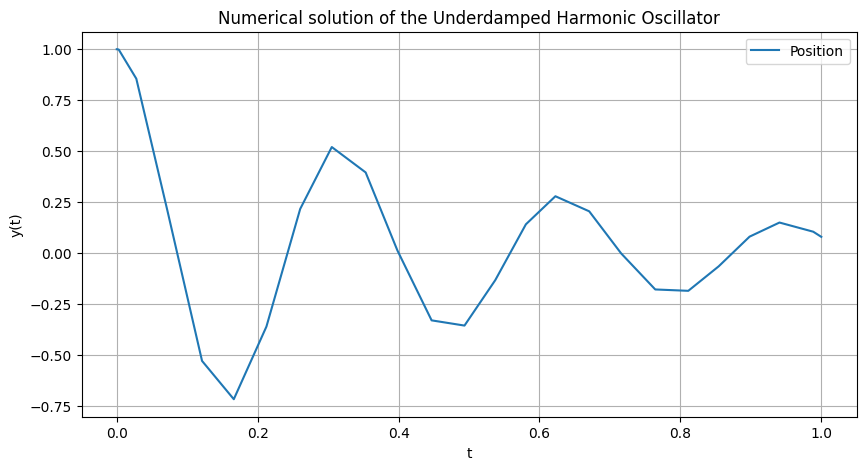

In [42]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import time

# Define the function representing the first-order system of ODEs
def harmonic_oscillator(t, y, mu, k):
    dydt = [y[1], -mu * y[1] - k * y[0]]
    return dydt

# Define parameters
d, w0 = 2, 20
mu = 2 * d
k = w0**2

# Define initial conditions
y0 = [1, 0]

# Define time span for integration
t_span = (0.0, 1.0)

# Integrate the ODEs using solve_ivp
start_train_time = time.time()
sol = solve_ivp(harmonic_oscillator, t_span, y0, args=(mu, k))
end_train_time = time.time()
ode_train_time = end_train_time - start_train_time

# Plot the solution
plt.figure(figsize=(10, 5))
plt.plot(sol.t, sol.y[0], label="Position")
plt.xlabel('t')
plt.ylabel('y(t)')
plt.title('Numerical solution of the Underdamped Harmonic Oscillator')
plt.legend()

plt.grid(True)
plt.show()

In [43]:
print(ode_train_time)

0.006154298782348633
